In [2]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.applications.vgg19 import VGG19
from keras.models import load_model
import tensorflow as tf
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

Using TensorFlow backend.


In [3]:
use_log_dir='X:/train-scene classification/logs_densenet' # Change for every new training session 

class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir=use_log_dir, **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()

In [14]:
img_width, img_height = 150, 150
train_data_dir = "X:/train-scene classification/data/train/"
validation_data_dir = "X:/train-scene classification/data/valid/"
test_data_dir = "X:/train-scene classification/data/test/"
nb_train_samples = 16384
nb_validation_samples = 650 
batch_size = 32
epochs = 1000
# Save the model according to the conditions  
chkpt_dir = "X:/train-scene classification/chkpts/densenet_retraining.h5" # Change for every new training session 

In [5]:
# model = DenseNet121(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3), classes = 6)

In [8]:
# model.save('densenet.h5')
model = load_model('densenet.h5')

In [9]:
# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
# for layer in model.layers[:200]:
#     layer.trainable = False

model.summary()
print(len(model.layers))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 75, 75, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [10]:
#Adding custom Layers 
x = model.output
# x = Flatten()(x)
# x = Dense(1024, activation="relu")(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation="relu")(x)
# x = Dropout(0.3)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(6, activation="softmax")(x)

In [11]:
# creating the final model 
model_final = Model(input = model.input, output = predictions)
model_final.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 75, 75, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

C:\Users\praty\Anaconda3\envs\dlenv\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [12]:
# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8), metrics=["accuracy"])

In [21]:
model_final.load_weights(chkpt_dir)

In [15]:
# Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
shear_range = 10,
fill_mode = "nearest",
zoom_range = 0.4,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=10)

validation_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
shear_range = 10,
fill_mode = "nearest",
zoom_range = 0.4,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=10)

train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")

validation_generator = validation_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
class_mode = "categorical")

Found 15000 images belonging to 6 classes.
Found 2034 images belonging to 6 classes.


In [16]:
# Save the model according to the conditions  
# chkpt_dir = "X:/train-scene classification/chkpts/densenet_extra_fc.h5" # Change for every new training session 

checkpoint = ModelCheckpoint(chkpt_dir, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=40, verbose=1, mode='auto')
#[TrainValTensorBoard(write_graph=False)]

In [17]:
import os

# Train the model 
model_final.fit_generator(
train_generator,
samples_per_epoch = nb_train_samples,
epochs = epochs,
validation_data = validation_generator,
nb_val_samples = nb_validation_samples,
callbacks = [checkpoint, early, TrainValTensorBoard(write_graph=False)])

C:\Users\praty\Anaconda3\envs\dlenv\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\praty\Anaconda3\envs\dlenv\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=1000, validation_data=<keras_pre..., callbacks=[<keras.ca..., steps_per_epoch=512, validation_steps=650)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/1000
512/512 [==============================] - 210s 410ms/step - loss: 0.6699 - acc: 0.7700 - val_loss: 1.1993 - val_acc: 0.5852

Epoch 00001: val_acc improved from -inf to 0.58524, saving model to X:/train-scene classification/chkpts/densenet_retraining.h5
Epoch 2/1000
512/512 [==============================] - 188s 368ms/step - loss: 0.4791 - acc: 0.8299 - val_loss: 0.4696 - val_acc: 0.8324

Epoch 00002: val_acc improved from 0.58524 to 0.83243, saving model to X:/train-scene classification/chkpts/densenet_retraining.h5
Epoch 3/1000
512/512 [==============================] - 188s 368ms/step - loss: 0.4446 - acc: 0.8441 - val_loss: 0.7173 - val_acc: 0.7627

Epoch 00003: val_acc did not improve from 0.83243
Epoch 4/1000
512/512 [==============================] - 188s 367ms/step - loss: 0.3995 - acc: 0.8612 - val_loss: 12.6469 - val_acc: 0.1932

Epoch 00004: val_acc did not improve from 0.83243
Epoch 5/1000
512/512 [==============================] - 191s 372ms/step - loss: 0.87

512/512 [==============================] - 194s 378ms/step - loss: 0.1872 - acc: 0.9305 - val_loss: 0.3616 - val_acc: 0.8769

Epoch 00041: val_acc did not improve from 0.90150
Epoch 42/1000
512/512 [==============================] - 192s 376ms/step - loss: 0.1927 - acc: 0.9294 - val_loss: 0.5226 - val_acc: 0.8238

Epoch 00042: val_acc did not improve from 0.90150
Epoch 43/1000
512/512 [==============================] - 194s 378ms/step - loss: 0.2056 - acc: 0.9231 - val_loss: 0.3602 - val_acc: 0.8722

Epoch 00043: val_acc did not improve from 0.90150
Epoch 44/1000
512/512 [==============================] - 193s 378ms/step - loss: 0.1898 - acc: 0.9307 - val_loss: 0.3371 - val_acc: 0.8845

Epoch 00044: val_acc did not improve from 0.90150
Epoch 45/1000
512/512 [==============================] - 194s 378ms/step - loss: 0.2864 - acc: 0.9004 - val_loss: 0.8930 - val_acc: 0.7410

Epoch 00045: val_acc did not improve from 0.90150
Epoch 46/1000
512/512 [==============================] - 193s 37

512/512 [==============================] - 188s 367ms/step - loss: 0.1096 - acc: 0.9591 - val_loss: 0.3920 - val_acc: 0.8896

Epoch 00082: val_acc did not improve from 0.90702
Epoch 83/1000
512/512 [==============================] - 188s 368ms/step - loss: 0.1075 - acc: 0.9614 - val_loss: 0.3694 - val_acc: 0.8939

Epoch 00083: val_acc did not improve from 0.90702
Epoch 84/1000
512/512 [==============================] - 189s 369ms/step - loss: 0.1036 - acc: 0.9622 - val_loss: 0.3366 - val_acc: 0.9019

Epoch 00084: val_acc did not improve from 0.90702
Epoch 85/1000
512/512 [==============================] - 188s 367ms/step - loss: 0.1065 - acc: 0.9579 - val_loss: 0.5449 - val_acc: 0.8700

Epoch 00085: val_acc did not improve from 0.90702
Epoch 86/1000
512/512 [==============================] - 188s 368ms/step - loss: 0.0988 - acc: 0.9643 - val_loss: 0.3129 - val_acc: 0.9039

Epoch 00086: val_acc did not improve from 0.90702
Epoch 87/1000
512/512 [==============================] - 191s 37

KeyboardInterrupt: 

In [ ]:
#Saving Model
# model_final.save("trained_densenet_retrain.h5")

## Testing + Predictions

In [18]:
model_final = load_model(chkpt_dir)

In [19]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
test_data_dir_2 = "X:/train-scene classification/data/test/final_test"

In [20]:
labels = (train_generator.class_indices)

labels = dict((v,k) for k,v in labels.items())
print(labels)
# predictions = [labels[k] for k in predicted_class_indices]

{0: '0_buildings', 1: '1_forest', 2: '2_glacier', 3: '3_mountain', 4: '4_sea', 5: '5_street'}


(150, 150, 3)
[5] 5_street


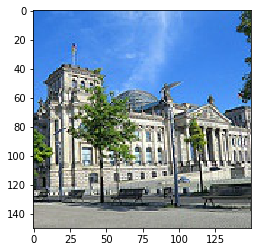

In [21]:

train_dir = "X:/train-scene classification/data/train/0_buildings"
img = cv2.imread(os.path.join(train_dir, "508.jpg"))

# train_dir = "X:/train-scene classification/data/valid/1_forest"
# img = cv2.imread(os.path.join(valid_dir, "597.jpg"))

# img = cv2.imread(os.path.join(test_data_dir_2, "121.jpg"))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
print(img.shape)
img = np.reshape(img, (1, img_width, img_height, 3))
img = img / 255.
pred = np.argmax(model_final.predict(img), axis=1)
print(pred, labels[pred[0]])

In [22]:
#### model = load_model("")

In [23]:
# test_datagen = ImageDataGenerator(rescale = 1./255)

In [24]:
# test_generator = test_datagen.flow_from_directory(
#     directory="X:/train-scene classification/data/test/",
#     target_size=(img_width, img_height),
#     color_mode="rgb",
#     batch_size=1,
#     class_mode=None,
#     shuffle=False,
#     seed=42
# )

In [25]:
# test_generator.reset()
# pred=model_final.predict_generator(test_generator,verbose=1)

# import numpy as np
# predicted_class_indices=np.argmax(pred,axis=1)

# print(predicted_class_indices[:20])
# print(predicted_class_indices.shape)
# print(pred.shape)

In [26]:
import pandas as pd
df = pd.read_csv(os.path.join("X:/train-scene classification", 'test_images.csv'))
print(df.head())
test_list = df.image_name.values
print(test_list[:20])

  image_name
0      3.jpg
1      5.jpg
2      6.jpg
3     11.jpg
4     14.jpg
['3.jpg' '5.jpg' '6.jpg' '11.jpg' '14.jpg' '22.jpg' '25.jpg' '28.jpg'
 '30.jpg' '38.jpg' '51.jpg' '52.jpg' '61.jpg' '63.jpg' '64.jpg' '69.jpg'
 '70.jpg' '72.jpg' '73.jpg' '76.jpg']


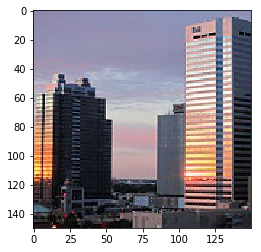

In [27]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
join_l = []
ans = []
test_data_dir_2 = "X:/train-scene classification/data/test/final_test"
for i, im in enumerate(test_list):
    img = cv2.imread(os.path.join(test_data_dir_2, im))
    if i == 1:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
    img = cv2.resize(img, (img_width, img_height)) 
    img = np.reshape(img, (1, img_width, img_height, 3))
    img = img / 255.
    pred = np.argmax(model_final.predict(img), axis=1)
    ans.append((im, pred))

# x_test = np.vstack(join_l)
# print(x_test.shape)

In [28]:
print(ans[0:10])

[('3.jpg', array([5], dtype=int64)), ('5.jpg', array([0], dtype=int64)), ('6.jpg', array([4], dtype=int64)), ('11.jpg', array([2], dtype=int64)), ('14.jpg', array([5], dtype=int64)), ('22.jpg', array([1], dtype=int64)), ('25.jpg', array([4], dtype=int64)), ('28.jpg', array([2], dtype=int64)), ('30.jpg', array([4], dtype=int64)), ('38.jpg', array([2], dtype=int64))]


In [29]:
print(ans[0][1].shape)

(1,)


In [30]:
li = []
for i in ans:
    pa = i[0]
    val= i[1][0]
    li.append([pa, val])
print(li[:10])

[['3.jpg', 5], ['5.jpg', 0], ['6.jpg', 4], ['11.jpg', 2], ['14.jpg', 5], ['22.jpg', 1], ['25.jpg', 4], ['28.jpg', 2], ['30.jpg', 4], ['38.jpg', 2]]


In [31]:
res_df = pd.DataFrame(li, columns=["image_name", "label"])
res_df.head()

,image_name,label
0,3.jpg,5
1,5.jpg,0
2,6.jpg,4
3,11.jpg,2
4,14.jpg,5


In [32]:
res_df.to_csv('submission_densenet_retrained.csv', index = False)